In [2]:
import torch
import phate
import scprep
import numpy as np
import matplotlib.pyplot as plt
from random import shuffle
import os
import sys

In [3]:
#Obtain tree data
#default params nbranch=5, branch_length=100
tree_data, tree_clusters = phate.tree.gen_dla(n_dim=10, n_branch=10, branch_length=200)

In [4]:
#Define phate operator
phate_operator = phate.PHATE(random_state=42)
tree_phate = phate_operator.fit_transform(tree_data)

Calculating PHATE...
  Running PHATE on 2000 observations and 10 variables.
  Calculating graph and diffusion operator...
    Calculating KNN search...
    Calculated KNN search in 0.07 seconds.
    Calculating affinities...
    Calculated affinities in 0.02 seconds.
  Calculated graph and diffusion operator in 0.09 seconds.
  Calculating optimal t...
    Automatically selected t = 25
  Calculated optimal t in 1.07 seconds.
  Calculating diffusion potential...
  Calculated diffusion potential in 0.47 seconds.
  Calculating metric MDS...
  Calculated metric MDS in 5.05 seconds.
Calculated PHATE in 6.70 seconds.


(2000, 10)
(2000, 2)
(2000,)


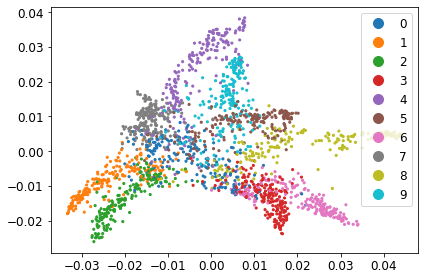

In [5]:
#PHATE plot of original data
cax = scprep.plot.scatter2d(tree_phate, c=tree_clusters)
print(tree_data.shape)
print(tree_phate.shape)
print(tree_clusters.shape)

In [6]:
#Store data in tensor

X = torch.tensor(tree_data, requires_grad=True)
n = tree_data.shape[0]
random_indices = np.random.randint(n, size=n)

In [7]:
#Define phate function


def torch_phate(X, kernel="gaussian", bandwidth=1000, t=10):
    dists = torch.norm(X[:, None] - X, dim=2, p="fro")

    def gaussian_kernel(x):
        return torch.exp(-(dists**2) / bandwidth)

    kernel = gaussian_kernel(dists)
    p = kernel / kernel.sum(axis=0)[:, None]
    pt = torch.matrix_power(p, t)
    log_p = torch.log(pt)
    return pt



With the Autoencoder

In [8]:
#Define Autoencoder class

import torch.nn as nn

class Autoencoder(nn.Module):
    def __init__(
        self,
        encoder_layer=[10, 10, 10],
        decoder_layer=[10, 10, 10],
        activation="ReLU",
        use_cuda=False,
    ) -> None:
        super().__init__()
        device = "cuda" if use_cuda else "cpu"
        
        c = 0
        encoder = []
        for i0, i1 in zip(encoder_layer, encoder_layer[1:]):
            c = c + 1
            encoder.append(nn.Linear(i0, i1))
            if c == 1:
                encoder.append(getattr(nn, "ReLU")())
            #else:
            #    encoder.append(getattr(nn, "ReLU")())
        print("Encoder",encoder)
        self.encoder = nn.Sequential(*encoder).to(device)
        
        c = 0
        decoder=[]
        for i0,i1 in zip(decoder_layer,decoder_layer[1:]):
            c = c + 1
            decoder.append(nn.Linear(i0, i1))
            if c == 1:
                decoder.append(getattr(nn,"ReLU")())
        print("Decoder",decoder)
        self.decoder = nn.Sequential(*decoder).to(device)
        
    

    def encode(self,x):
        x = self.encoder()
        return x

    def decode(self,x):
        x = self.decoder(x)
        return x

In [22]:
##### Define Model Characteristics

use_cuda = torch.cuda.is_available()
phate_ae = Autoencoder(
    encoder_layer=[10, 10, 2], decoder_layer=[2, 10, 10], use_cuda=use_cuda)


optimizer = torch.optim.AdamW(phate_ae.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=50, gamma=0.05)

n_epochs = 500
n_train = int(n*0.6)

#Get random train indices
fullind = np.arange(tree_data.shape[0])
random_indices = np.random.choice(
    fullind, size=n_train, replace=False
)  

#Define batch size
batch_size = 64
n_batches = int(n_train/batch_size)

train_loss_a = []
for epoch in range(n_epochs):
    
    #zero gradients
    optimizer.zero_grad()
    
    #shuffle indices
    np.random.shuffle(random_indices)
    X_sample = X[random_indices].float()  # Get 100 samples
    P = torch_phate(X_sample,kernel="gaussian",bandwidth=1,t=10).cuda()  # Get log proability
    
    #add noise
    noise = (
        (torch.randn(X_sample.size())).cuda()
        if use_cuda
        else torch.randn(X_sample.size())
    )  # define noise from Gaussian distribution
    
    
    for i in range(n_batches):
        
        xbatch = X_sample[i*batch_size:(i*batch_size)+batch_size].detach() #get batch for samples
        pbatch = P[i*batch_size:(i*batch_size)+batch_size].cuda().detach() #get batch for phate embedding
        nbatch = noise[i*batch_size:(i*batch_size)+batch_size].detach() #get batch for noise
        
        xbatch.requires_grad = True
        pbatch.requires_grad = True
        nbatch.requires_grad = True
        
        
        encode_sample = phate_ae.encoder(
           xbatch.cuda() + nbatch.cuda()
        )  # encode phate into 2 dimensions

        geom_loss = nn.MSELoss()(
            torch.cdist(encode_sample, encode_sample) ** 2, torch.cdist(pbatch, pbatch) ** 2
        )  # Loss between encoded space and diffusion distance


        decode_sample = phate_ae.decode(encode_sample)  # decode embedding
        recon_loss = nn.MSELoss()(decode_sample,xbatch.cuda())  # Loss decoded embedding and original
     
        if epoch < 10000:
            loss = recon_loss + (geom_loss)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        else:
            scheduler.step()
            loss = recon_loss + (geom_loss)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
    train_loss_a.append(loss)
    
    

    if epoch % 50 == 0:
        #print(recon_loss)
        #print(geom_loss)
        print("Loss distance :", loss)


        

Encoder [Linear(in_features=10, out_features=10, bias=True), ReLU(), Linear(in_features=10, out_features=2, bias=True)]
Decoder [Linear(in_features=2, out_features=10, bias=True), ReLU(), Linear(in_features=10, out_features=10, bias=True)]
Loss distance : tensor(175.2105, device='cuda:0', grad_fn=<AddBackward0>)
Loss distance : tensor(42.9115, device='cuda:0', grad_fn=<AddBackward0>)
Loss distance : tensor(31.5239, device='cuda:0', grad_fn=<AddBackward0>)
Loss distance : tensor(33.1687, device='cuda:0', grad_fn=<AddBackward0>)
Loss distance : tensor(35.5954, device='cuda:0', grad_fn=<AddBackward0>)
Loss distance : tensor(30.1537, device='cuda:0', grad_fn=<AddBackward0>)
Loss distance : tensor(29.9554, device='cuda:0', grad_fn=<AddBackward0>)
Loss distance : tensor(31.7237, device='cuda:0', grad_fn=<AddBackward0>)
Loss distance : tensor(25.3502, device='cuda:0', grad_fn=<AddBackward0>)
Loss distance : tensor(25.7944, device='cuda:0', grad_fn=<AddBackward0>)


Text(0.5, 0, 'Number of epochs')

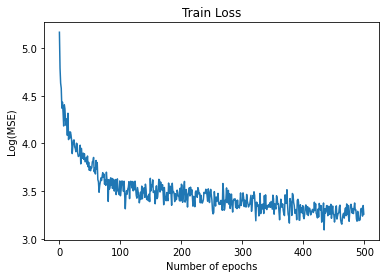

In [23]:
#Plot train loss
ctrain = torch.stack(train_loss_a).detach().cpu().numpy()

plt.title("Train Loss")
plt.plot(np.log(ctrain))
plt.ylabel("Log(MSE)")
plt.xlabel("Number of epochs")

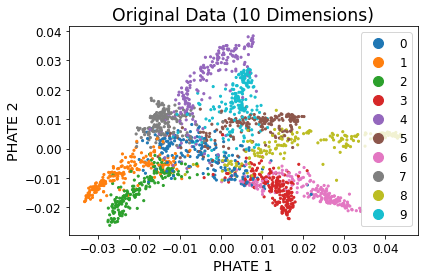

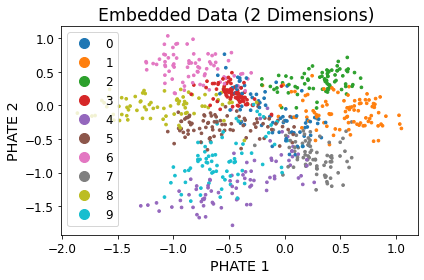

In [24]:



# Get test indices
testind = []
fullind = list(np.arange(tree_data.shape[0]))
for i in fullind:
    if i not in random_indices:
        testind.append(i)

testind = np.array(testind)

# Get samples from autoencoder


nxsample = phate_ae.encoder(X[testind].float().cuda())
xsampout = nxsample.detach().cpu().numpy()




# Visualize ground truth
cax = scprep.plot.scatter2d(
    tree_phate,
    c=tree_clusters,
    title="Original Data (10 Dimensions)",
    xlabel="PHATE 1",
    ylabel="PHATE 2",
)


# Visualize Embedding
cax = scprep.plot.scatter2d(xsampout, c=tree_clusters[testind], title="Embedded Data (2 Dimensions) ",xlabel="PHATE 1",ylabel="PHATE 2")


# Compute Jacobian
Jacob = []
for i in testind:
    X_sample = X[i].float().cuda()
    J = torch.autograd.functional.jacobian(phate_ae.encoder, X_sample).squeeze()
    Jacob.append(J.cpu().detach().numpy())

AJacob = np.array(Jacob)
prod = np.empty((X.shape[1],X.shape[1]))


#Compute FIM
FIM = []
for k in range(xsampout.shape[0]):
    prod = np.empty((X.shape[1],X.shape[1]))
    for i in range(AJacob.shape[2]):
        for j in range(AJacob.shape[2]):
            prod[i,j] = np.sum(AJacob[k,:,i] * AJacob[k,:,j] * np.exp(xsampout[k,:]))

    FIM.append(prod)



    


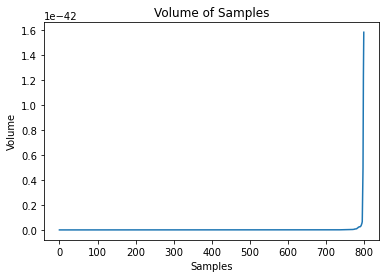

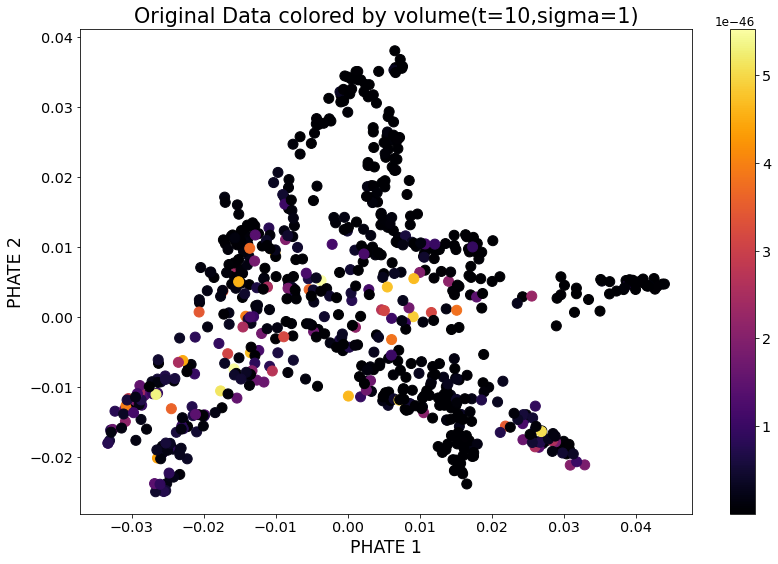

In [25]:
# Analysis/Data Visualization

#Compute Volume
V = np.sqrt(np.abs(np.linalg.det(np.array(FIM))))

#Remove outliers (Take all points within two standard deviations [95%])
Vmedian = np.median(V)
sortind = np.argsort(np.abs(V - Vmedian))[:int(0.90*len(V))]


    

plt.plot(np.sort(V))
plt.title("Volume of Samples")
plt.ylabel("Volume")
plt.xlabel("Samples")




# Visualize ground truth
cax = scprep.plot.scatter2d(
    tree_phate[testind[sortind]],
    c=V[sortind],
    title="Original Data colored by volume(t=10,sigma=1)",
    fontsize=12,
    xlabel="PHATE 1",
    ylabel="PHATE 2",
    figsize = (12,8),
    s = 100
)


V = np.expand_dims(V[sortind],axis=1) #Expand for concatenation
Vtree = np.concatenate((tree_phate[testind[sortind]],V),axis=1)
np.save("Vtree_t_tten_sigone.npy",Vtree)
